# Sector Neutral

## Save sectors

In [2]:
import os
import yfinance as yf
# get list of files in ../data/ directory
import glob
import pandas as pd
import sys
import tqdm

# get file name of files in a directory

tickers = [file.split('.')[0] for file in os.listdir('../../Data/data/eod-quotemedia/daily')]

sectors=[]
tickr=[]
for ticker in tqdm.tqdm(tickers):
    tick = yf.Ticker(ticker)
    try:
        sectors.append(tick.info['sector'])
        tickr.append(ticker)
    except:
        sectors.append('Others')
        tickr.append(ticker)

ticker_data = pd.DataFrame({'ticker': tickr, 'sector': sectors}).to_csv('../../Data/sectors.csv',index=False)

100%|██████████| 408/408 [02:42<00:00,  2.50it/s]


In [ ]:
!{sys.executable} -m pip install -r requirements.txt

In [1]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## following zipline bundle documentation

http://www.zipline.io/bundles.html#ingesting-data-from-csv-files

### data bundle

# Get Returns data

In [2]:
import numpy as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
import os
from zipline.data import bundles
import zipline.data.bundles as bundles
import pandas as pd
from zipline.data.bundles import register, yahoo_NYSE, csvdir
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import engine as pipeline_engine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.domain import US_EQUITIES
from zipline.data.data_portal import DataPortal


def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'))
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'))

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

def choose_price_loader(column):
        if column not in USEquityPricing.columns:
            print("Column not in USEquityPricing.columns")
        return pricing_loader


register(
        'yahoo_NYSE',
        yahoo_NYSE.yahoo_NYSE(
            tframes=["daily"],
            csvdir="/home/ankit/AI_for_trading/Data/data/eod-quotemedia/"
        )
    )

bundle_data = bundles.load('yahoo_NYSE')
    ### Build pipeline engine


# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader,fx_reader=None)


engine = pipeline_engine.SimplePipelineEngine(choose_price_loader,asset_finder=bundle_data.asset_finder)


universe_end_date = pd.Timestamp('2017-01-06')


    
# define screen
universe = AverageDollarVolume(window_length=120).top(500) 

# get tickers that satify screen
universe_tickers = engine\
        .run_pipeline(
            Pipeline(screen=universe,domain=US_EQUITIES),
            universe_end_date,
            universe_end_date)\
        .index.get_level_values(1)\
        .values.tolist()
        

# get trading calender
trading_calendar = get_calendar('NYSE') 

data_portal = DataPortal(
        bundle_data.asset_finder,
        trading_calendar=trading_calendar,
        first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
        equity_minute_reader=None,
        equity_daily_reader=bundle_data.equity_daily_bar_reader,
        adjustment_reader=bundle_data.adjustment_reader)



returns =  get_pricing(
            data_portal,
            trading_calendar,
            universe_tickers,
            universe_end_date - pd.DateOffset(years=2),
            universe_end_date)\
        .pct_change()[1:].fillna(0) #convert prices into returns

   

/tmp/ipykernel_8852/3892058998.py:42: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


In [4]:
returns.head()

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABT]),Equity(6 [ACN]),Equity(7 [ADBE]),Equity(8 [ADI]),Equity(9 [ADM]),...,Equity(398 [WYNN]),Equity(399 [XEL]),Equity(400 [XOM]),Equity(401 [XRAY]),Equity(402 [XRX]),Equity(403 [XYL]),Equity(404 [YUM]),Equity(405 [ZBH]),Equity(406 [ZION]),Equity(407 [ZTS])
2015-01-08,0.029975,0.012262,0.008765,0.038384,0.010459,0.020554,0.015249,0.025454,0.017655,-0.014609,...,0.012031,0.011599,0.016645,0.024689,0.027531,0.007546,0.017404,0.010623,0.013994,0.015399
2015-01-09,-0.007337,-0.030563,-0.005089,0.001108,-0.027355,-0.010508,-0.001113,-0.014811,-0.000730,-0.008530,...,0.012499,-0.012285,-0.001410,-0.014569,-0.005798,-0.018863,-0.001758,-0.014427,-0.027975,0.001584
2015-01-12,-0.011826,-0.046905,-0.008546,-0.024676,-0.000304,0.008407,-0.003007,-0.010022,-0.010051,-0.012495,...,-0.003958,-0.008845,-0.019218,-0.009477,-0.010199,-0.021770,-0.007480,0.002370,-0.015349,-0.018757
2015-01-13,-0.013962,0.016539,-0.032530,0.008897,-0.036040,-0.021281,0.003575,-0.007452,-0.011445,0.001452,...,0.009093,0.008087,-0.003653,-0.003062,0.005166,0.002312,-0.004121,0.002191,-0.017147,-0.014049
2015-01-14,-0.012389,-0.019643,-0.019056,-0.003811,0.004890,-0.007397,-0.011689,-0.008500,-0.000747,-0.017191,...,-0.008077,0.008852,-0.002889,-0.014587,0.004389,-0.006344,-0.004138,-0.013219,-0.017050,0.005139


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [3]:
import pandas as pd
import numpy as np
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype

class Sector(Classifier):
    dtype = int64_dtype  # Assuming sector IDs are integers
    window_length = 0
    inputs = ()
    missing_value = -1  # Use -1 for missing sectors

    def __init__(self):

        asset_finder = bundle_data.asset_finder

        # Load the CSV with stock symbols and sector IDs
        self.sector_data = pd.read_csv('../../Data/sectors.csv').set_index('ticker')['sector'].to_dict()

       # Create a reverse mapping from SIDs to symbols
        self.symbol_to_sector = self.sector_data
        self.asset_finder = asset_finder

    def _compute(self, arrays, dates, assets, mask):

        
        # Check the type of assets
        # Convert zipline assets (Asset objects) to stock symbols
        symbols = [self.asset_finder.retrieve_asset(asset).symbol for asset in assets]
       

        # Map symbols to their sector IDs using the CSV data
        sectors = np.array([self.sector_data.get(symbol, self.missing_value) for symbol in symbols])


        # Return sectors where mask is True, otherwise return missing_value
        return np.where(mask, sectors, self.missing_value)


## Create an alpha factor based on momentum

We want to calculate the one-year return.  
In other words, get the close price of today, minus the close price of 252 trading days ago, and divide by that price from 252 days ago.

$1YearReturn_t = \frac{price_{t} - price_{t-252}}{price_{t-252}}$

In [4]:
from zipline.pipeline.factors import Returns

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [5]:
universe_end_date = pd.Timestamp('2017-01-06')

factor_start_date = universe_end_date - pd.DateOffset(years=2)
factor_start_date

Timestamp('2015-01-06 00:00:00')

In [6]:
## 1 year returns can be the basis for an alpha factor
p1 = Pipeline(screen=universe,domain=US_EQUITIES)
rets1 = Returns(window_length=252, mask=universe)
p1.add(rets1,"1YearReturns")
df1 = engine.run_pipeline(p1, factor_start_date, universe_end_date)

In [63]:
#graphviz lets us visualize the pipeline
import graphviz

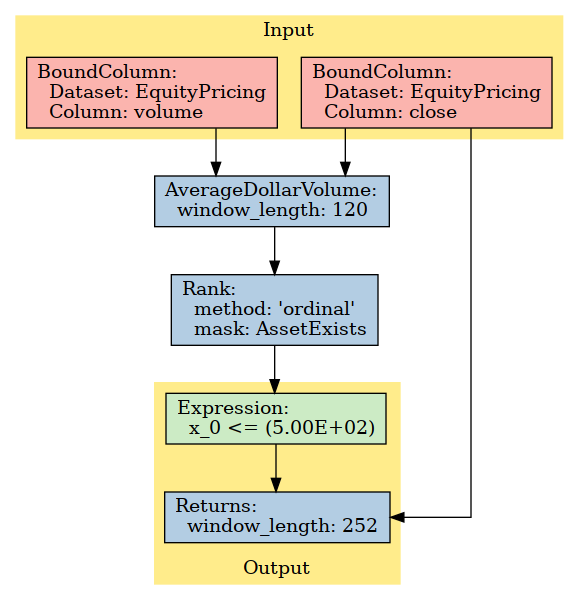

In [64]:
p1.show_graph(format='png')

## View the data of the factor

In [65]:
df1.head()

1YearReturns
2015-01-06 Equity(0 [A])        -0.017648
           Equity(1 [AAL])       0.993341
           Equity(2 [AAP])       0.399553
           Equity(3 [AAPL])      0.367343
           Equity(4 [ABBV])      0.282993

## Explore the demean function

The Returns class inherits from zipline.pipeline.factors.factor.  
[The documentation for demean is located here](https://www.zipline.io/appendix.html#zipline.pipeline.factors.Factor.demean), and is also pasted below:

```
demean(mask=sentinel('NotSpecified'), groupby=sentinel('NotSpecified'))[source]
Construct a Factor that computes self and subtracts the mean from row of the result.

If mask is supplied, ignore values where mask returns False when computing row means, and output NaN anywhere the mask is False.

If groupby is supplied, compute by partitioning each row based on the values produced by groupby, de-meaning the partitioned arrays, and stitching the sub-results back together.

Parameters:	
mask (zipline.pipeline.Filter, optional) – A Filter defining values to ignore when computing means.
groupby (zipline.pipeline.Classifier, optional) – A classifier defining partitions over which to compute means.
```

## Quiz 2

By looking at the documentation, and then the source code for `demean`, what are two parameters for this function?  Which one or ones would you call if you wanted to demean by sector and wish to demean for all values in the chosen universe?

[The source code](https://www.zipline.io/_modules/zipline/pipeline/factors/factor.html#Factor.demean) has useful comments to help you answer this question.

### Answer
We would use the groupby parameter, and we don't need to use the mask parameter, since we are not going to exclude any of the stocks in the universe from the demean calculation.

## Quiz 3
Turn 1 year returns into an alpha factor

We can do some processing to convert our signal (1 year return) into an alpha factor. One step is to demean by sector.

* demean
For each stock, we want to take the average return of stocks that are in the same sector, and then remove this from the return of each individual stock.

## Answer 3

In [7]:
# create a pipeline called p2
p2 = Pipeline(screen=universe,domain=US_EQUITIES)
# create a factor of one year returns, deman by sector
factor_demean_by_sector = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()) )

# add the factor to the p2 pipeline
p2.add(factor_demean_by_sector, 'Momentum_1YR_demean_by_sector')


## visualize the second pipeline

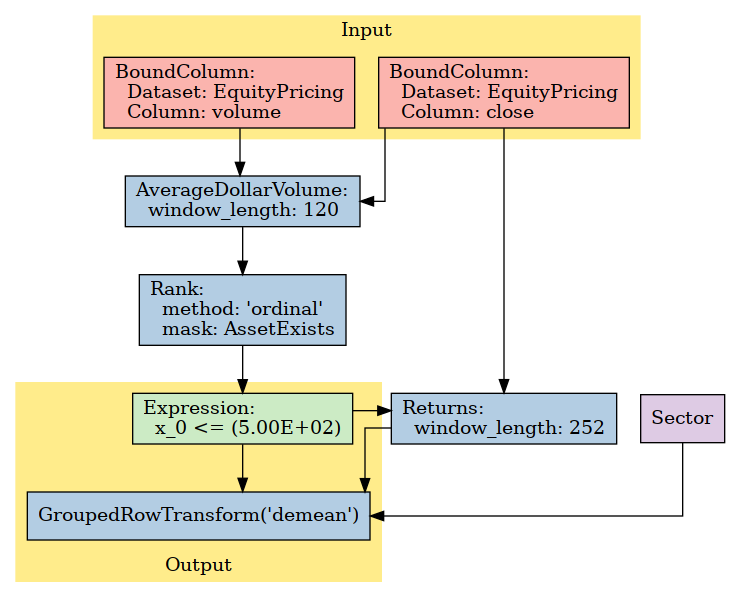

In [67]:
p2.show_graph(format='png')

## Quiz 4
How does this pipeline compare with the first pipeline that we created earlier?

## Answer 4 here


## run pipeline and view the factor data

In [8]:
df2 = engine.run_pipeline(p2, factor_start_date, universe_end_date)

In [9]:
df2

Momentum_1YR_demean_by_sector
2015-01-06 Equity(0 [A])                           -0.293722
           Equity(1 [AAL])                          0.836856
           Equity(2 [AAP])                          0.246739
           Equity(3 [AAPL])                         0.142938
           Equity(4 [ABBV])                         0.006918
...                                                      ...
2017-01-06 Equity(403 [XYL])                        0.158150
           Equity(404 [YUM])                        0.181748
           Equity(405 [ZBH])                       -0.049533
           Equity(406 [ZION])                       0.427454
           Equity(407 [ZTS])                        0.079639

[206448 rows x 1 columns]

### Rank 

Create a factor of one year returns, demeaned, and ranked



In [12]:
from zipline.pipeline.factors import Returns
#TODO
# create a pipeline called p

p = Pipeline(screen=universe,domain=US_EQUITIES)

# create a factor of one year returns, deman by sector, then rank
demean_factor = Returns(window_length=252, mask=universe).demean(groupby=Sector()).rank()

# add the factor to the pipeline

p.add(demean_factor, 'Momentum_1YR_demean_by_sector_ranked')

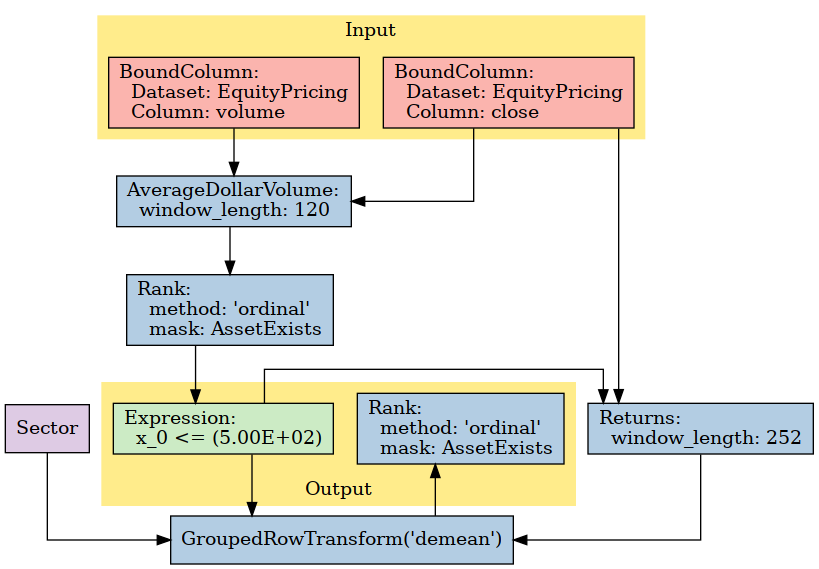

In [13]:
p.show_graph(format='png')

In [14]:
# run pipeline
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [15]:
df

Momentum_1YR_demean_by_sector_ranked
2015-01-06 Equity(0 [A])                                       14.0
           Equity(1 [AAL])                                    405.0
           Equity(2 [AAP])                                    379.0
           Equity(3 [AAPL])                                   349.0
           Equity(4 [ABBV])                                   233.0
...                                                             ...
2017-01-06 Equity(403 [XYL])                                  342.0
           Equity(404 [YUM])                                  352.0
           Equity(405 [ZBH])                                  176.0
           Equity(406 [ZION])                                 396.0
           Equity(407 [ZTS])                                  291.0

[206448 rows x 1 columns]

### Z score

Explore the zscore function
The documentation for zscore is located here, and is also pasted below:

Construct a Factor that Z-Scores each day’s results.

The Z-Score of a row is defined as:

(row - row.mean()) / row.stddev()
If mask is supplied, ignore values where mask returns False when computing row means and standard deviations, and output NaN anywhere the mask is False.

If groupby is supplied, compute by partitioning each row based on the values produced by groupby, z-scoring the partitioned arrays, and stitching the sub-results back together.

Parameters:	
mask (zipline.pipeline.Filter, optional) – A Filter defining values to ignore when Z-Scoring.
groupby (zipline.pipeline.Classifier, optional) – A classifier defining partitions over which to compute Z-Scores.
Returns:	
zscored – A Factor producing that z-scores the output of self.

Return type:	
zipline.pipeline.Factor

In [24]:
from zipline.pipeline.factors import Returns
#TODO
# create a pipeline called p
p = Pipeline(screen=universe,domain=US_EQUITIES)
# create a factor of one year returns, deman by sector, then rank
factor_sector_deman = Returns(window_length=252, mask=universe).demean(groupby=Sector()).rank().zscore()
# add the factor to the pipeline

p.add(factor_sector_deman, 'Momentum_1YR_demean_by_sector_ranked_zscore')


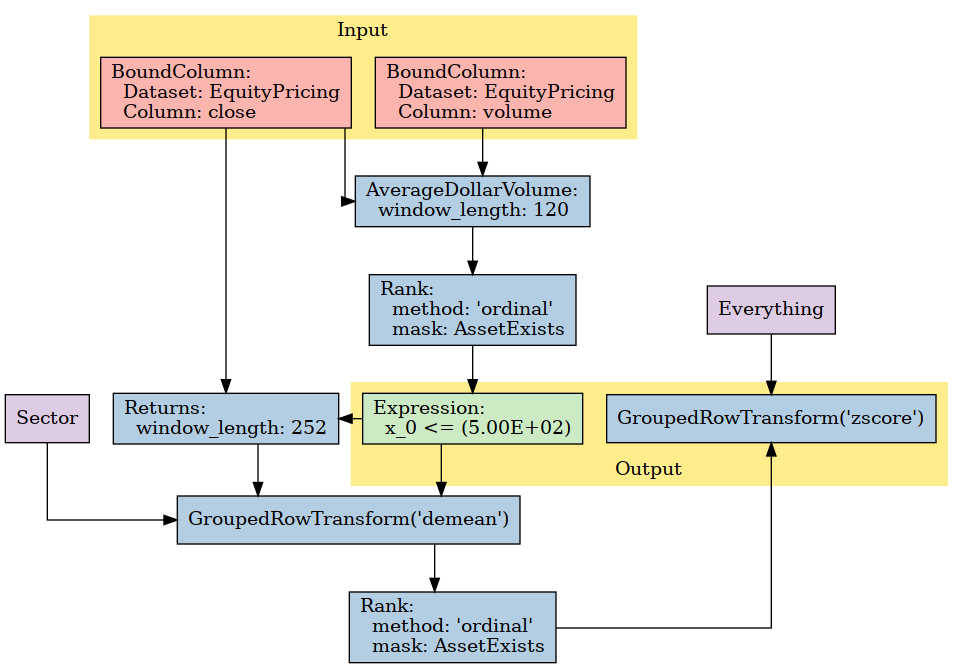

In [25]:
p.show_graph(format='png')

In [26]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

In [27]:
df

Momentum_1YR_demean_by_sector_ranked_zscore
2015-01-06 Equity(0 [A])                                         -1.617435
           Equity(1 [AAL])                                        1.702339
           Equity(2 [AAP])                                        1.481587
           Equity(3 [AAPL])                                       1.226873
           Equity(4 [ABBV])                                       0.241978
...                                                                    ...
2017-01-06 Equity(403 [XYL])                                      1.167440
           Equity(404 [YUM])                                      1.252344
           Equity(405 [ZBH])                                     -0.241978
           Equity(406 [ZION])                                     1.625925
           Equity(407 [ZTS])                                      0.734426

[206448 rows x 1 columns]

### Smoothing 

In [32]:
from zipline.pipeline.factors import Returns
from zipline.pipeline.factors import SimpleMovingAverage

# create a pipeline called p
p = Pipeline(screen=universe,domain=US_EQUITIES)
# create a factor of one year returns, deman by sector, then rank
factor = (
    Returns(window_length=252, mask=universe).
    demean(groupby=Sector()). #we use the custom Sector class that we reviewed earlier
    rank().
    zscore()
)


# Use this factor as input into SimpleMovingAverage, with a window length of 5
# Also rank and zscore (don't need to de-mean by sector, s)
factor_smoothed = (
    SimpleMovingAverage(inputs=[factor], window_length=5).
    rank().
    zscore()
)

# add the unsmoothed factor to the pipeline
p.add(factor, 'Momentum_Factor')
# add the smoothed factor to the pipeline too
p.add(factor_smoothed, 'Smoothed_Momentum_Factor')


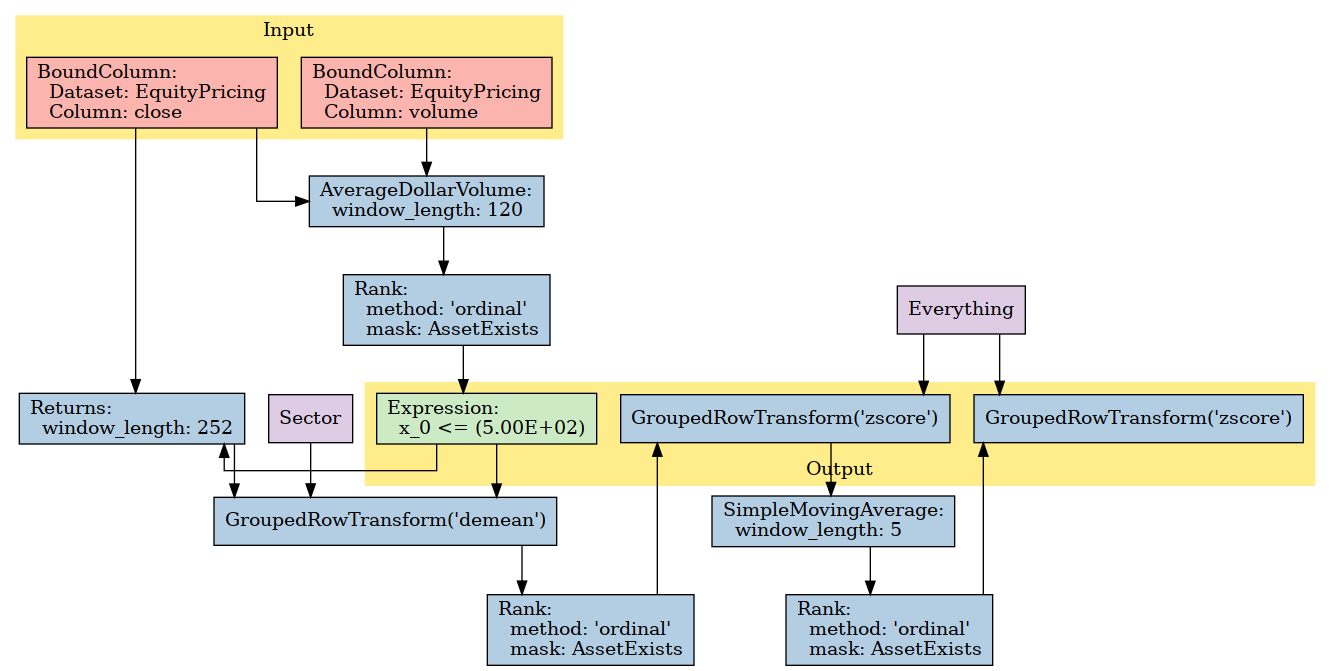

In [33]:
p.show_graph(format='png')

In [34]:
df = engine.run_pipeline(p, factor_start_date, universe_end_date)

df

Momentum_Factor  Smoothed_Momentum_Factor
2015-01-06 Equity(0 [A])             -1.617435                 -1.574982
           Equity(1 [AAL])            1.702339                  1.702339
           Equity(2 [AAP])            1.481587                  1.532530
           Equity(3 [AAPL])           1.226873                  1.294797
           Equity(4 [ABBV])           0.241978                  0.038207
...                                        ...                       ...
2017-01-06 Equity(403 [XYL])          1.167440                  1.260835
           Equity(404 [YUM])          1.252344                  1.286306
           Equity(405 [ZBH])         -0.241978                 -0.148583
           Equity(406 [ZION])         1.625925                  1.625925
           Equity(407 [ZTS])          0.734426                  0.810840

[206448 rows x 2 columns]

In [35]:
df.index.get_level_values(1)[0:5]


Index([   Equity(0 [A]),  Equity(1 [AAL]),  Equity(2 [AAP]), Equity(3 [AAPL]),
       Equity(4 [ABBV])],
      dtype='object')

In [36]:
# TODO
# get the level value for AAPL (it's at row index 3)
stock_index_name = df.index.get_level_values(1)[3]

print(type(stock_index_name))
print(stock_index_name)

<class 'zipline.assets._assets.Equity'>
Equity(3 [AAPL])


In [37]:
#notice, we'll put the stock_index_name inside of a list
single_stock_df = df[np.in1d(df.index.get_level_values(1), [stock_index_name])]
single_stock_df.head()

,,Momentum_Factor,Smoothed_Momentum_Factor
2015-01-06,Equity(3 [AAPL]),1.226873,1.294797
2015-01-07,Equity(3 [AAPL]),1.328759,1.294797
2015-01-08,Equity(3 [AAPL]),1.345740,1.303287
2015-01-09,Equity(3 [AAPL]),1.422154,1.320268
2015-01-12,Equity(3 [AAPL]),1.464606,1.345740


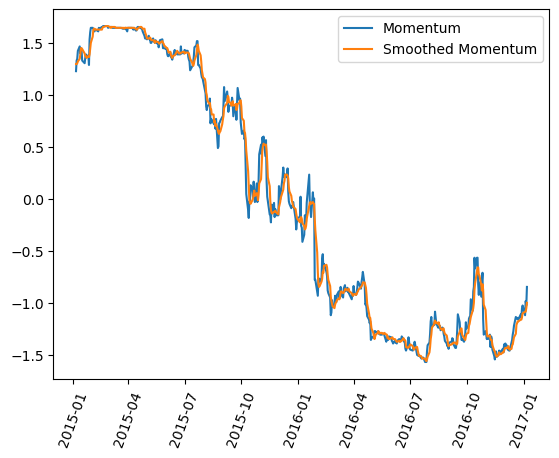

In [55]:
# import mticker
import matplotlib.ticker as mticker
fig,ax = plt.subplots()
# single_stock_df['Momentum_Factor'].plot(label='momentum')
# single_stock_df['Smoothed_Momentum_Factor'].plot(style='--', label='smoothed momentum')
ax.plot(single_stock_df.index.get_level_values(0),single_stock_df['Momentum_Factor'],label='Momentum')
ax.plot(single_stock_df.index.get_level_values(0),single_stock_df['Smoothed_Momentum_Factor'],label='Smoothed Momentum')
# rotate the x labels
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 )
ax.legend()
plt.show()